<img src='http://hilpisch.com/tpq_logo.png' width="350px" align="right">

# AI-Powered Algorithmic Trading with Python

**ODSC London 2023**

Dr. Yves J. Hilpisch | The Python Quants & The AI Machine

https://tpq.io | https://aimachine.io | [@dyjh](http://twitter.com/dyjh)

<a href="https://home.tpq.io/certificates/pyalgo" target="_blank"><img src="https://hilpisch.com/aiif_cover_shadow.png" width="300px" align="left"></a>

### Case Study: AI-Powered Strategy

## Oanda API 

In [1]:
import tpqoa
import numpy as np
import pandas as pd

In [2]:
from pylab import plt
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = 'svg'

In [3]:
import warnings
warnings.simplefilter('ignore')

In [5]:
oanda = tpqoa.tpqoa('oanda.cfg')

## The Data 

In [6]:
%%time
data = oanda.get_history(
    instrument='BCO_USD',
    start='2023-06-14',
    end='2023-06-15',
    granularity='S5',
    price='M'
)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11435 entries, 2023-06-14 00:00:00 to 2023-06-14 21:57:55
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         11435 non-null  float64
 1   h         11435 non-null  float64
 2   l         11435 non-null  float64
 3   c         11435 non-null  float64
 4   volume    11435 non-null  int64  
 5   complete  11435 non-null  bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 547.2 KB
CPU times: total: 203 ms
Wall time: 4.46 s


In [7]:
data['r'] = np.log(data['c'] / data['c'].shift(1))

In [8]:
data['d'] = np.sign(data['r'])

## The Strategy 

In [9]:
lags = 3

In [10]:
cols = list()
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['r'].shift(lag)
    cols.append(col)

In [11]:
data.head()

,o,h,l,c,volume,complete,r,d,lag_1,lag_2,lag_3
time,,,,,,,,,,,
2023-06-14 00:00:00,74.159,74.164,74.159,74.164,2,True,NaN,NaN,NaN,NaN,NaN
2023-06-14 00:00:05,74.169,74.169,74.139,74.139,8,True,-0.000337,-1.0,NaN,NaN,NaN
2023-06-14 00:00:10,74.159,74.159,74.134,74.134,3,True,-0.000067,-1.0,-0.000337,NaN,NaN
2023-06-14 00:00:15,74.114,74.134,74.114,74.129,7,True,-0.000067,-1.0,-0.000067,-0.000337,NaN
2023-06-14 00:00:25,74.124,74.124,74.114,74.114,2,True,-0.000202,-1.0,-0.000067,-0.000067,-0.000337


In [12]:
data.dropna(inplace=True)

In [13]:
data['d'] = data['d'].astype(int)

## Train-Test Split

In [14]:
split = int(len(data) * 0.8)
split

9144

In [15]:
train = data.iloc[:split].copy()

In [16]:
mu, std = train.mean(), train.std()

In [17]:
train_ = (train - mu) / std

In [18]:
test = data.iloc[split:].copy()

In [19]:
test_ = (test - mu) / std

## Training of the Model

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [22]:
model = MLPClassifier(hidden_layer_sizes=[24],
                      shuffle=False,
                      max_iter=500)

In [23]:
model.fit(train_[cols], train['d'])

MLPClassifier(hidden_layer_sizes=[24], max_iter=500, shuffle=False)

In [24]:
accuracy_score(train['d'], model.predict(train_[cols]))

0.43832020997375326

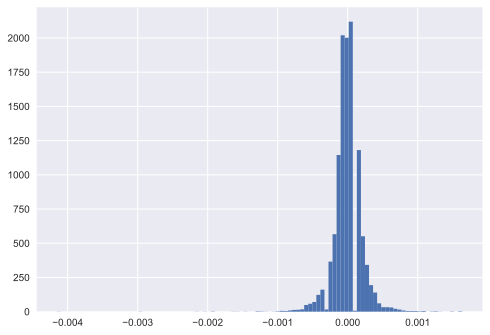

In [25]:
data['r'].hist(bins=100);

## Testing of the Model

In [26]:
test['p'] = model.predict(test_[cols])

In [27]:
accuracy_score(test['d'], test['p'])

0.4372540445999126

In [28]:
test['s'] = test['p'] * test['r']

In [29]:
test[['r', 's']].sum().apply(np.exp)

r    0.992232
s    1.015406
dtype: float64

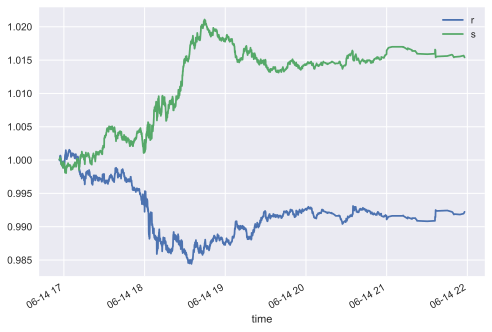

In [30]:
test[['r', 's']].cumsum().apply(np.exp).plot();

## Trading Code

In [31]:
oanda.on_success??

Signature: oanda.on_success(time, bid, ask)
Source:   
    def on_success(self, time, bid, ask):
        ''' Method called when new data is retrieved. '''
        print(time, bid, ask)
File:      d:\2024\april\major project\env\lib\site-packages\tpqoa\tpqoa.py
Type:      method

In [32]:
oanda.stream_data('BCO_USD', stop=10)  # streaming data

2024-05-15T06:43:26.262744865Z 83.236 83.276
2024-05-15T06:43:27.241676506Z 83.246 83.276
2024-05-15T06:43:34.704141466Z 83.246 83.286
2024-05-15T06:43:46.802430272Z 83.246 83.276
2024-05-15T06:43:50.509197886Z 83.236 83.266
2024-05-15T06:43:58.077934748Z 83.226 83.266
2024-05-15T06:43:58.189696701Z 83.226 83.256
2024-05-15T06:44:02.977980143Z 83.226 83.266
2024-05-15T06:44:20.144395992Z 83.236 83.266
2024-05-15T06:44:20.515211068Z 83.226 83.266


In [33]:
oanda.create_order('BCO_USD', units=100)  # opening long position



 {'id': '22', 'time': '2024-05-15T06:44:25.753081597Z', 'userID': 29105169, 'accountID': '101-001-29105169-001', 'batchID': '22', 'requestID': '79253994051599723', 'type': 'MARKET_ORDER_REJECT', 'instrument': 'BCO_USD', 'units': '100.0', 'timeInForce': 'FOK', 'positionFill': 'DEFAULT', 'reason': 'CLIENT_ORDER', 'rejectReason': 'INSTRUMENT_NOT_TRADEABLE'} 



In [34]:
oanda.create_order('BCO_USD', units=-100)  # closing long position



 {'id': '23', 'time': '2024-05-15T06:44:36.157539490Z', 'userID': 29105169, 'accountID': '101-001-29105169-001', 'batchID': '23', 'requestID': '97268392606533034', 'type': 'MARKET_ORDER_REJECT', 'instrument': 'BCO_USD', 'units': '-100.0', 'timeInForce': 'FOK', 'positionFill': 'DEFAULT', 'reason': 'CLIENT_ORDER', 'rejectReason': 'INSTRUMENT_NOT_TRADEABLE'} 



## Simple Deployment

In [35]:
model.predict(test[cols])[-1]

1

In [36]:
class MLPTrader(tpqoa.tpqoa):
    def __init__(self, config_file, model, lags):
        super().__init__(config_file)
        self.model = model
        self.min_length = lags
        self.position = 0
        self.units = 100
        self.tick_data = pd.DataFrame()
    def on_success(self, time, bid, ask):
        trade = False
        print(self.ticks, end=' ')
        df = pd.DataFrame({'b': bid, 'a': ask, 'm': (ask + bid) / 2},
                         index=[pd.Timestamp(time).tz_localize(tz=None)])
        self.tick_data = pd.concat((self.tick_data, df))
        # resampling the tick data to 5 second intervals
        self.data = self.tick_data.resample('5s', label='right').last().ffill()
        self.data['r'] = np.log(self.data['m'] / self.data['m'].shift(1))
        self.data.dropna(inplace=True)
        if len(self.data) > self.min_length:
            self.min_length += 1
            # checking for long signal
            prediction = self.model.predict(
                self.data['m'].iloc[-lags-1:-1].values.reshape(1, -1))
            print(prediction)
            if prediction == 1 and self.position in [0, -1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=(1 - self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING LONG ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = 1
            # checking for short signal
            elif prediction == -1 and self.position in [0, 1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=-(1 + self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING SHORT ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = -1    

In [38]:
mt = MLPTrader('oanda.cfg', model, lags=lags)
mt.stream_data('BCO_USD', stop=150)

1 2 3 4 5 6 [-1]

*** GOING SHORT ***
7 [-1]
8 [-1]
9 [-1]
10 [-1]
11 [-1]
12 [-1]
13 [-1]
14 [-1]
15 [-1]
16 [-1]
17 [-1]
18 [-1]
19 [-1]
20 [-1]
21 [-1]
22 [-1]
23 [-1]
24 [-1]
25 [-1]
26 [-1]
27 [-1]
28 [-1]
29 [-1]
30 [-1]
31 [-1]
32 [-1]
33 [-1]
34 [-1]


KeyboardInterrupt: 

In [39]:
from pprint import pprint
o = mt.create_order('BCO_USD', units=-mt.position * mt.units,
                    suppress=True, ret=True)
print('\n*** POSITION CLOSED ***')
mt.print_transactions(tid=int(o['id']) - 1)
print('\n')
pprint(o)


*** POSITION CLOSED ***


{'accountID': '101-001-29105169-001',
 'batchID': '25',
 'id': '25',
 'instrument': 'BCO_USD',
 'positionFill': 'DEFAULT',
 'reason': 'CLIENT_ORDER',
 'rejectReason': 'INSTRUMENT_NOT_TRADEABLE',
 'requestID': '61239596477324480',
 'time': '2024-05-15T06:48:08.662546569Z',
 'timeInForce': 'FOK',
 'type': 'MARKET_ORDER_REJECT',
 'units': '100.0',
 'userID': 29105169}


<img src='http://hilpisch.com/tpq_logo.png' width="350px" align="right">